<a href="https://colab.research.google.com/github/RWLab/macro-pod/blob/main/research/VIX_Futures_vs_SPX_Options_Basis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Trading the VIX Futures basis from the SPX term structure

Notebook from webinar here: TBC

The core here is that VIX futures are more likely to get distorted than SPX options.

So we use SPX options (via the cboe vix indices) to finger-in-the-air price the VIX futures.

TBC - More documentation

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c("roll"), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpuHErCs/remotesbd1a873760/RWLab-rwRtools-41678d9/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.35.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

# Get VIX Futures Data

In [15]:
vx <- rwRtools::macro_get_expiring_vx_futures() %>%
  mutate(
    date = as_date(date),
    expiry = as_date(expiry)
  )
vx %>% head()

ℹ Downloading vx_futures_1d_ohlc.feather

✔ Saved vx_futures_1d_ohlc.feather to macropod/vx_futures_1d_ohlc.feather  ( 6.…





File successfully transferred


ticker,contract_name,date,open,high,low,close,volume,open_interest,tick_size,currency,point_value,margin,type,exchange,expiry
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<date>
VX-2004K,CBOE Volatility Index May 2004,2004-03-26,21.24,21.25,20.27,20.32,216,144,0.05,USD,1000,10120,Stock Index,CBOE,2004-05-19
VX-2004K,CBOE Volatility Index May 2004,2004-03-29,19.90,19.99,19.75,19.80,52,113,0.05,USD,1000,10120,Stock Index,CBOE,2004-05-19
VX-2004K,CBOE Volatility Index May 2004,2004-03-30,19.86,20.04,19.61,19.62,93,159,0.05,USD,1000,10120,Stock Index,CBOE,2004-05-19
VX-2004K,CBOE Volatility Index May 2004,2004-03-31,19.67,19.81,19.67,19.75,562,684,0.05,USD,1000,10120,Stock Index,CBOE,2004-05-19
VX-2004K,CBOE Volatility Index May 2004,2004-04-01,19.87,19.99,19.62,19.62,84,708,0.05,USD,1000,10120,Stock Index,CBOE,2004-05-19
VX-2004K,CBOE Volatility Index May 2004,2004-04-02,19.47,19.47,18.84,18.89,89,804,0.05,USD,1000,10120,Stock Index,CBOE,2004-05-19


# Check expirations are right

Kris fixed the expirations in the raw data... check it works. should return no records.

In [8]:
# Check the expirations
expiry <- read_csv('https://drive.google.com/uc?export=download&id=12qfEGhTo_WsglUJmEOAEt0FxIHkMhTBP')

vx %>% inner_join(expiry, by='ticker') %>%
  filter(expiry.x != expiry.y)

Rows: 256 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
date (1): expiry

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ticker,contract_name,date,open,high,low,close,volume,open_interest,tick_size,currency,point_value,margin,type,exchange,expiry.x,expiry.y
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<date>,<date>


Check if we're missing data - look at earliest missing contract... should be 10-12 months in the future.

In [16]:
expiry %>% anti_join(vx, by='ticker') %>% head()

ticker,expiry
<chr>,<date>
VX-2024H,2024-03-20
VX-2024J,2024-04-17
VX-2024K,2024-05-22
VX-2024M,2024-06-18
VX-2024N,2024-07-17
VX-2024Q,2024-08-21


# Calculate daily summary data

In [17]:
vx_contracts <- vx %>%
  # Calculate returns per contract
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(logreturn = log(close/lag(close))) %>%
  # Calculate DTEs and costant maturity series
  group_by(date) %>%
  mutate(DTE = as.numeric(expiry - date) - 1) %>%
  # Remove contracts that expire today or tomorrow (VIX futures expire at 9am eastern)
  filter(DTE >= 0) %>%
  # Calculate distance from 30DTE position
  mutate(
    contract = row_number(DTE), 
    dist30 = abs(DTE - 30)
  ) %>%
  # Remove all but the first two contracts
  filter(contract <=2) %>%
  # If the earliest contract has DTE >= 30, we only want one contract
  filter(contract == 1 | min(DTE) < 30) %>%
  # Calculate weights for each contract
  mutate(weight30 = case_when(
    # If DTE >= 30 set the full weight to that contract
    min(DTE) >= 30 ~ 1,
    # Otherwise weught between the two contracts
    TRUE ~ (sum(dist30) - dist30) / sum(dist30) 
    )
  ) %>%
  ungroup() %>%
  # Only keep the columns we need 
  select(ticker, contract_name, date, close, expiry, logreturn, DTE, contract, dist30, weight30)

Check data integrity. 

We should have:
 - no negative weights
 - DTE of the weighted contracts should be 30. (It'll be higher for some of the early dates where we don't have two contracts stradding 30DTE)

ticker,contract_name,date,close,expiry,logreturn,DTE,contract,dist30,weight30
<chr>,<chr>,<date>,<dbl>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>


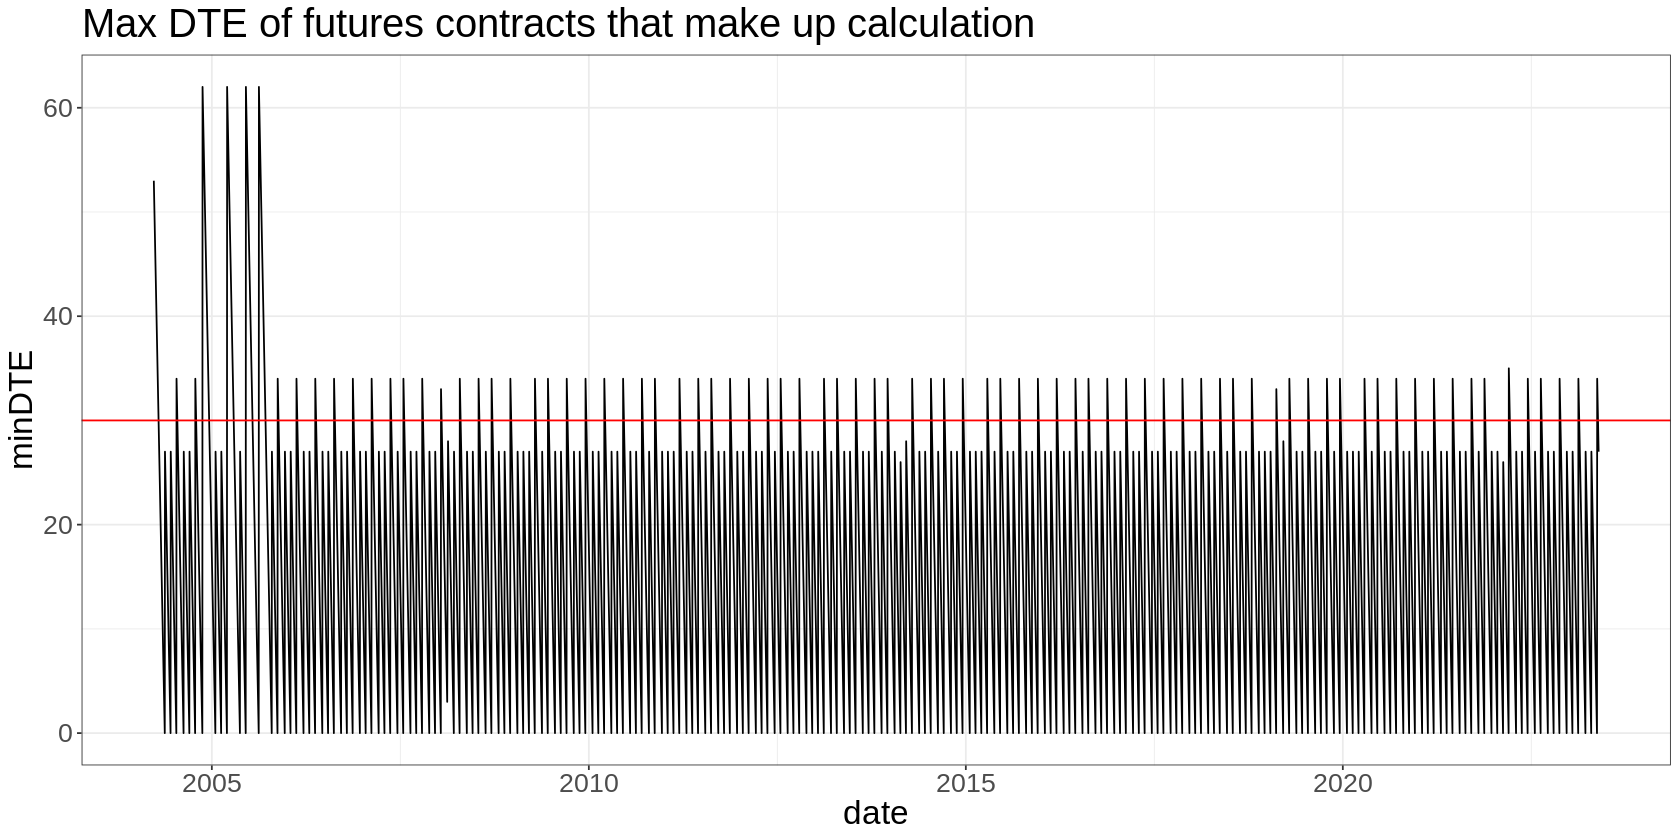

In [18]:
vx_contracts %>%
  filter(weight30 < 0)

vx_contracts %>%
  group_by(date) %>%
  summarize(minDTE = min(DTE)) %>%
  ggplot(aes(x=date, y=minDTE)) + 
    geom_line() + 
    geom_hline(yintercept = 30, color='red') +
    ggtitle('Max DTE of futures contracts that make up calculation')

Data dodgy at the end, as we know. But most shows a repeating seasonal pattern. I think that will be due to 31 day months meaning that sometimes there isn't actually a monthly VIX future available with < 30 days on.


Yep. Now plot the effective calendar DTE 

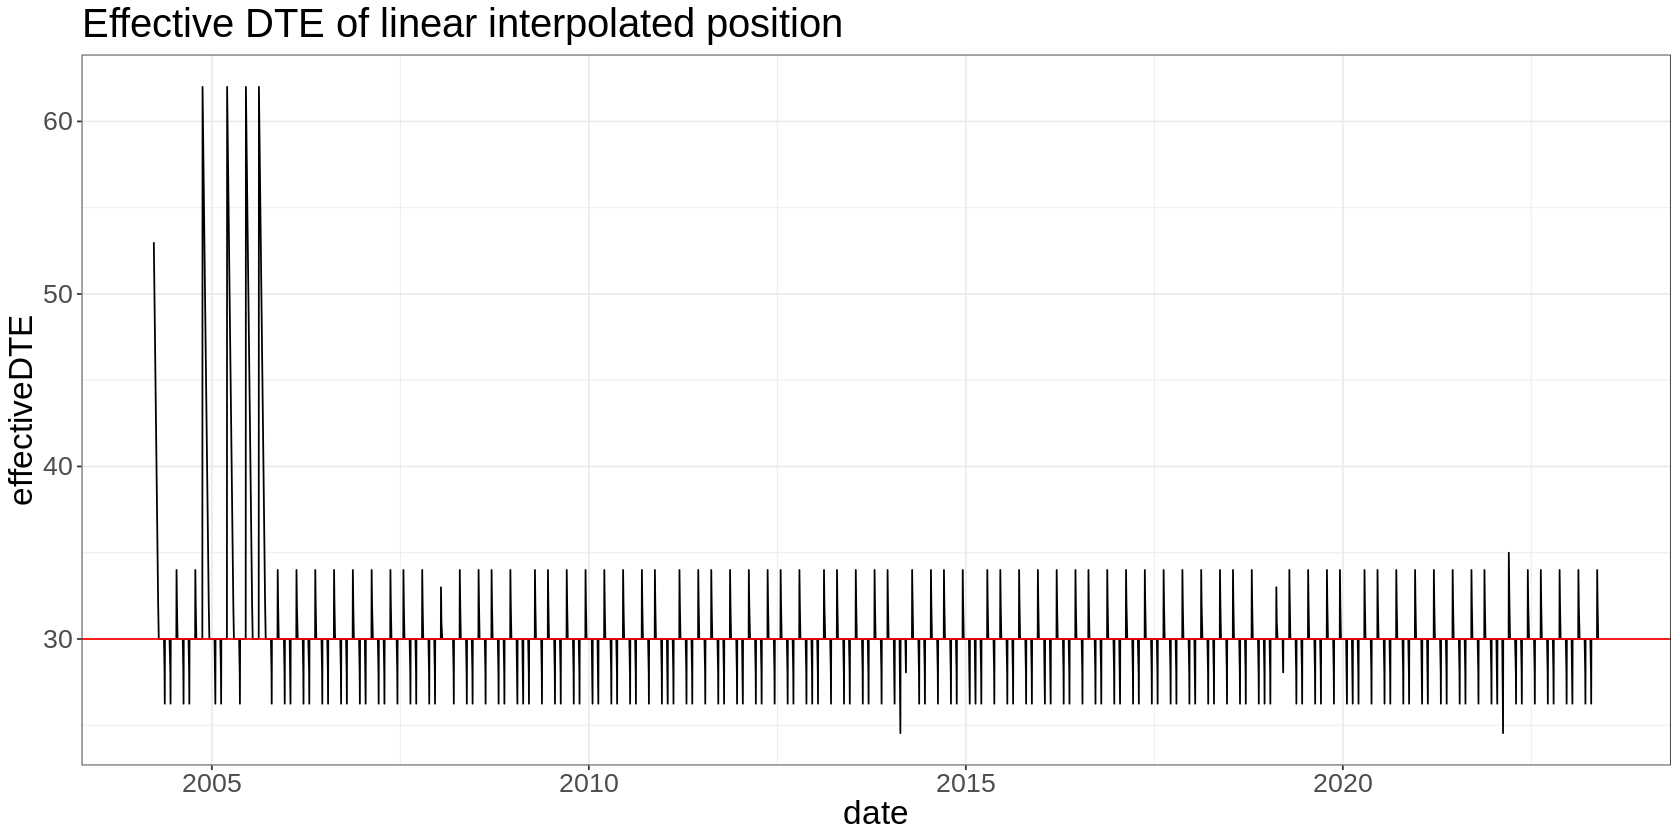

In [19]:
vx_contracts %>% 
  group_by(date) %>%
  summarize(effectiveDTE = sum(DTE * weight30)) %>%
  ggplot(aes(x=date, y=effectiveDTE)) + 
    geom_line() + 
    geom_hline(yintercept = 30, color='red') +
    ggtitle('Effective DTE of linear interpolated position')

which ones are less than 30?

In [22]:
vx_contracts %>% 
  group_by(date) %>%
  summarize(effectiveDTE = sum(DTE * weight30)) %>%
  filter(year(date) == 2020 & effectiveDTE < 30) %>% head()

date,effectiveDTE
<date>,<dbl>
2020-01-03,30.00000
2020-01-21,26.25000
2020-01-31,30.00000
2020-02-18,26.25000
2020-02-28,30.00000
2020-03-16,28.06667


In [21]:
vx_contracts %>% 
  filter(date == '2020-01-21')

ticker,contract_name,date,close,expiry,logreturn,DTE,contract,dist30,weight30
<chr>,<chr>,<date>,<dbl>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
VX-2020F,CBOE Volatility Index January 2020,2020-01-21,12.925,2020-01-22,0.03143677,0,1,30,0.0625
VX-2020G,CBOE Volatility Index February 2020,2020-01-21,15.075,2020-02-19,0.01000008,28,2,2,0.9375


These are cases where VX2 has less than 30 days on it. 

One of the challenges of working in days, innit.

I know SPVIXSTR only uses VX1 and VX2... maybe they just accept this, or use a different daycount with 0DTE as the morning expiration day.

Anyway... let's accept it for now.

Summarize to daily observations

In [23]:
vx_summary <- vx_contracts %>% 
  group_by(date) %>%
  mutate(
    vx1 = contract == 1,
    vx2 = contract == 2,
  ) %>%
  summarize(
    vx1_DTE = sum(vx1 * DTE),
    vx2_DTE = sum(vx2 * DTE),
    vx1_weight_30 = sum(vx1 * weight30),
    vx2_weight_30 = sum(vx2 * weight30),
    vx1 = sum(vx1 * close),
    vx2 = sum(vx2 * close),
    vx30 = sum(weight30 * close),
    vx30_tr = sum(weight30 * logreturn),
  )

  vx_summary %>% head()

date,vx1_DTE,vx2_DTE,vx1_weight_30,vx2_weight_30,vx1,vx2,vx30,vx30_tr
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004-03-26,53,0,1,0,20.32,0,20.32,NA
2004-03-29,50,0,1,0,19.80,0,19.80,-0.025923685
2004-03-30,49,0,1,0,19.62,0,19.62,-0.009132484
2004-03-31,48,0,1,0,19.75,0,19.75,0.006604037
2004-04-01,47,0,1,0,19.62,0,19.62,-0.006604037
2004-04-02,46,0,1,0,18.89,0,18.89,-0.037916773


# Plot stuff

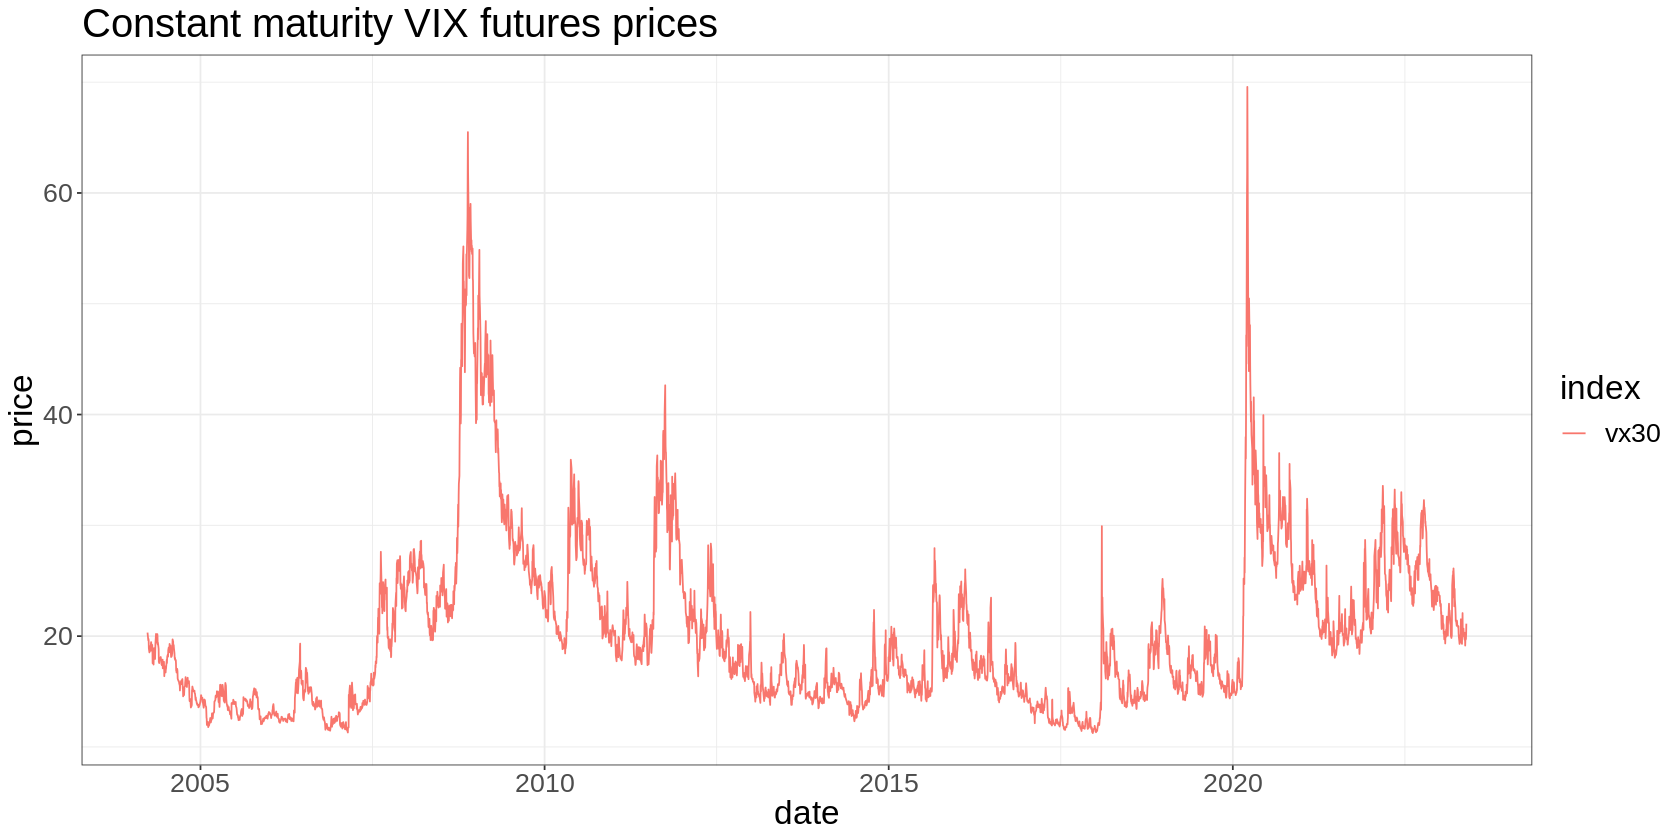

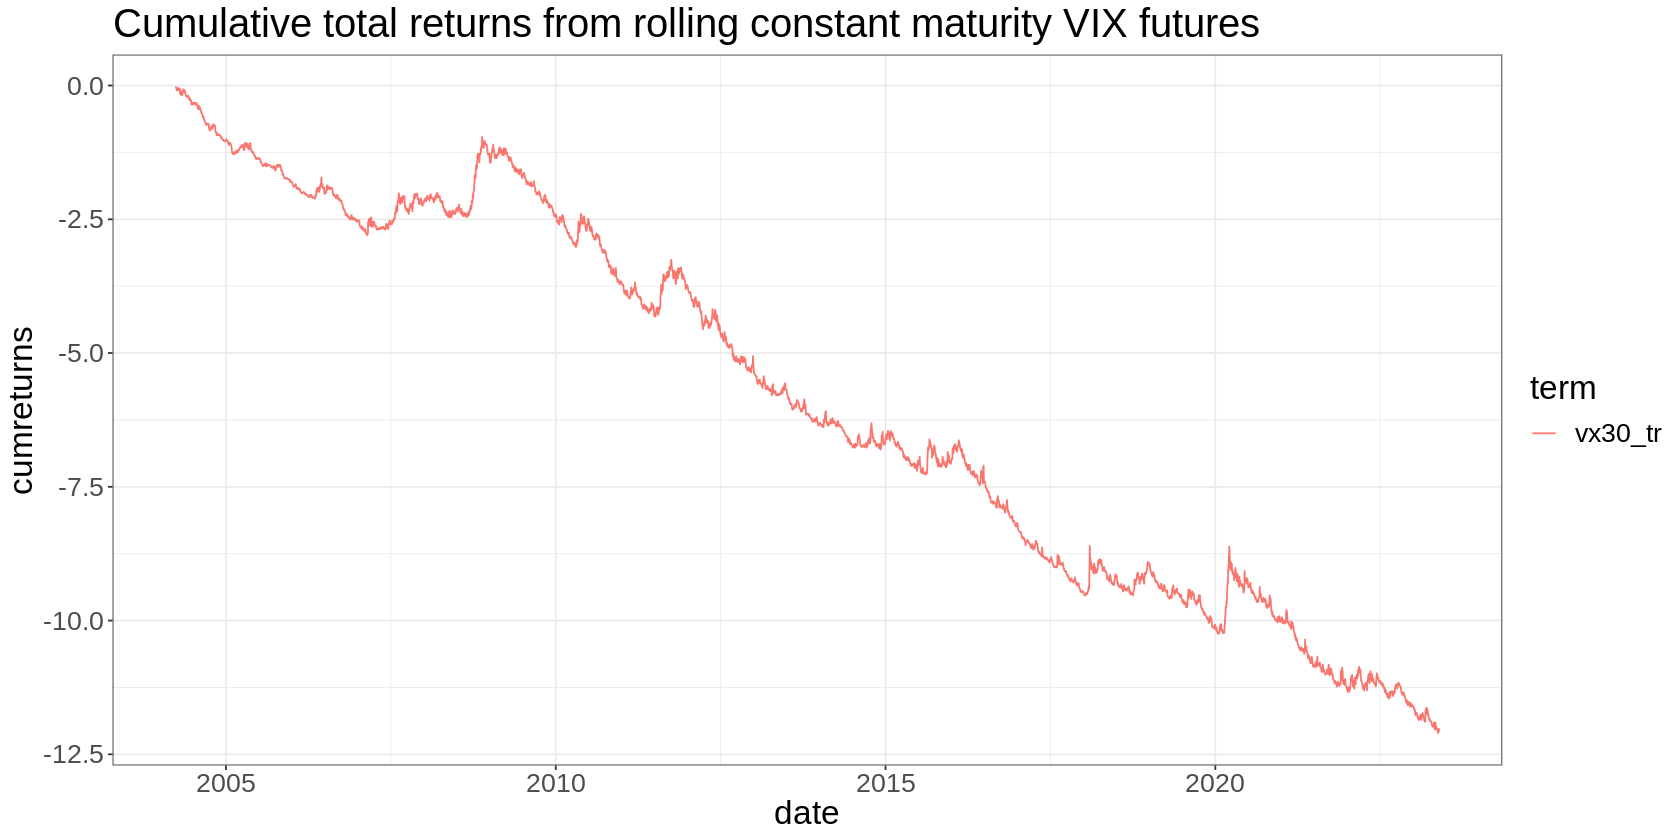

In [24]:
vx_summary %>% 
  select(date, vx30) %>%
  pivot_longer(-date, names_to = 'index', values_to = 'price') %>%
  ggplot(aes(x=date, y=price, color=index)) + 
    geom_line() +
    ggtitle('Constant maturity VIX futures prices')

vx_summary %>% 
  select(date, vx30_tr) %>%
  pivot_longer(-date, names_to = 'term', values_to = 'returns') %>%
  group_by(term) %>%
  arrange(date) %>%
  na.omit() %>%
  mutate(cumreturns = cumsum(returns)) %>%
  ggplot(aes(x=date, y=cumreturns, color=term)) + 
    geom_line() +
    ggtitle('Cumulative total returns from rolling constant maturity VIX futures')

# Get VIX index data

ℹ Downloading vix_vix3m.csv

✔ Saved vix_vix3m.csv to macropod/vix_vix3m.csv  ( 476.5 Kb )





File successfully transferred


Rows: 12796 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (4): open, high, low, close
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


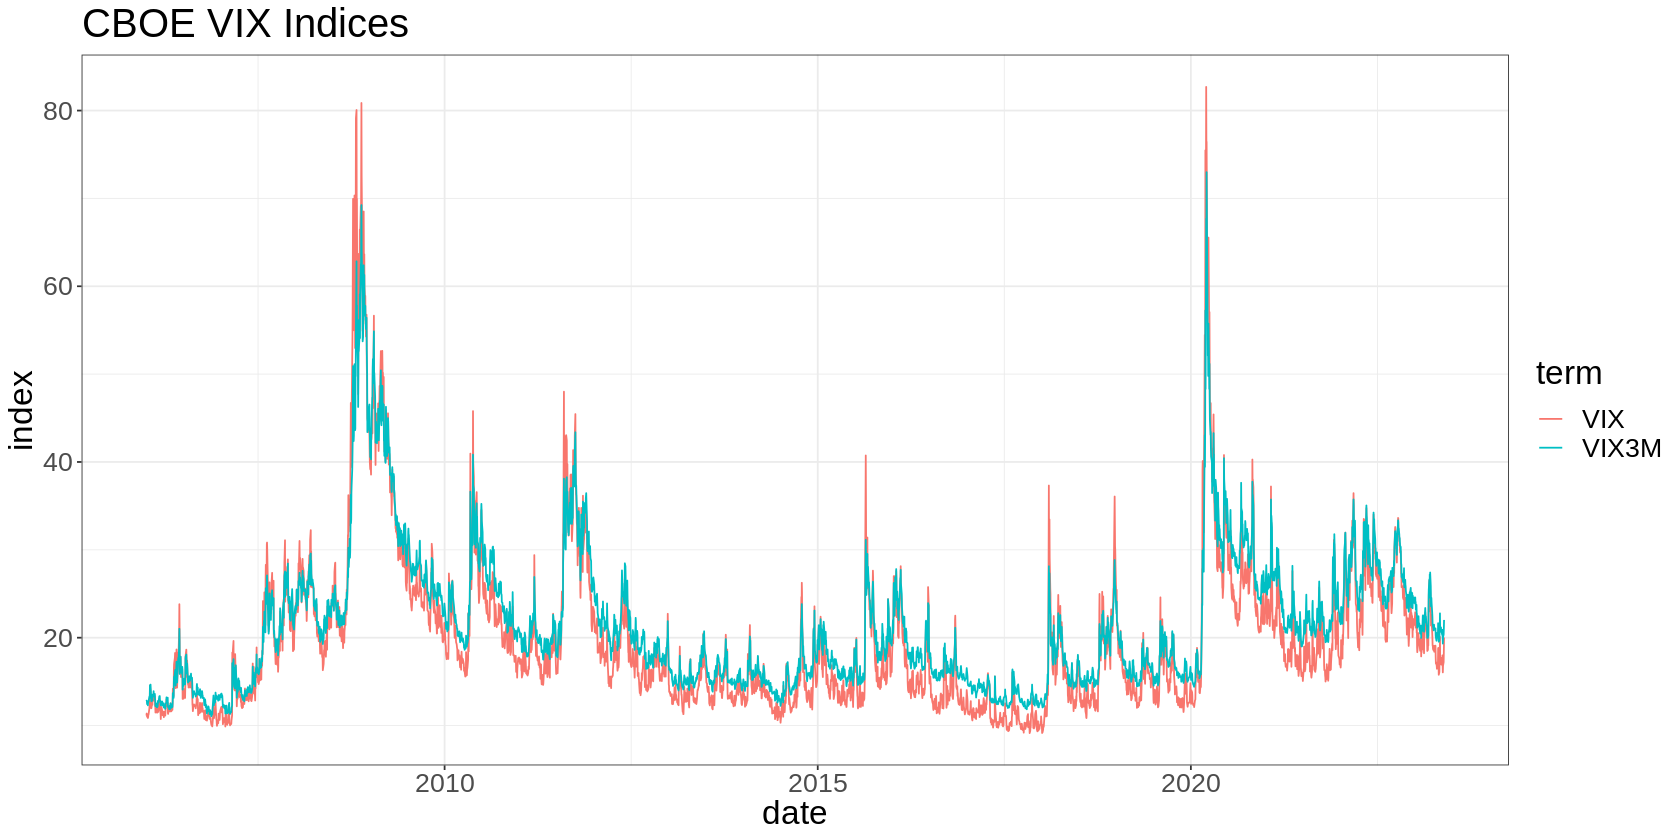

In [25]:
vix_indexes <- macro_get_vix_vix3m() %>%
  filter(ticker %in% c('VIX','VIX3M')) %>%
  select(ticker, date, close) %>%
  pivot_wider(names_from = ticker, values_from = close) %>%
  na.omit()

vix_indexes %>% 
  pivot_longer(-date, names_to='term', values_to='index') %>%
  ggplot(aes(x=date, y=index, color=term)) + geom_line() +
    ggtitle('CBOE VIX Indices')

Calculate the difference between VX30 and VIX3M

date,vx1_DTE,vx2_DTE,vx1_weight_30,vx2_weight_30,vx1,vx2,vx30,vx30_tr,VIX,VIX3M,premium
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2006-01-03,14,42,0.4285714,0.5714286,12.02,13.88,13.08286,-0.023644509,11.14,12.77,0.02420409
2006-01-04,13,41,0.3928571,0.6071429,11.84,13.84,13.05429,-0.007679764,11.37,12.84,0.01655119
2006-01-05,12,40,0.3571429,0.6428571,11.83,13.73,13.05143,-0.005431595,11.31,12.79,0.02023398
2006-01-06,11,39,0.3214286,0.6785714,11.56,13.53,12.89679,-0.017378290,11.00,12.44,0.03606102
2006-01-09,8,36,0.2142857,0.7857143,11.33,13.29,12.87000,-0.018368831,11.13,12.50,0.02917038
2006-01-10,7,35,0.1785714,0.8214286,11.22,13.04,12.71500,-0.017341362,10.86,12.30,0.03318314


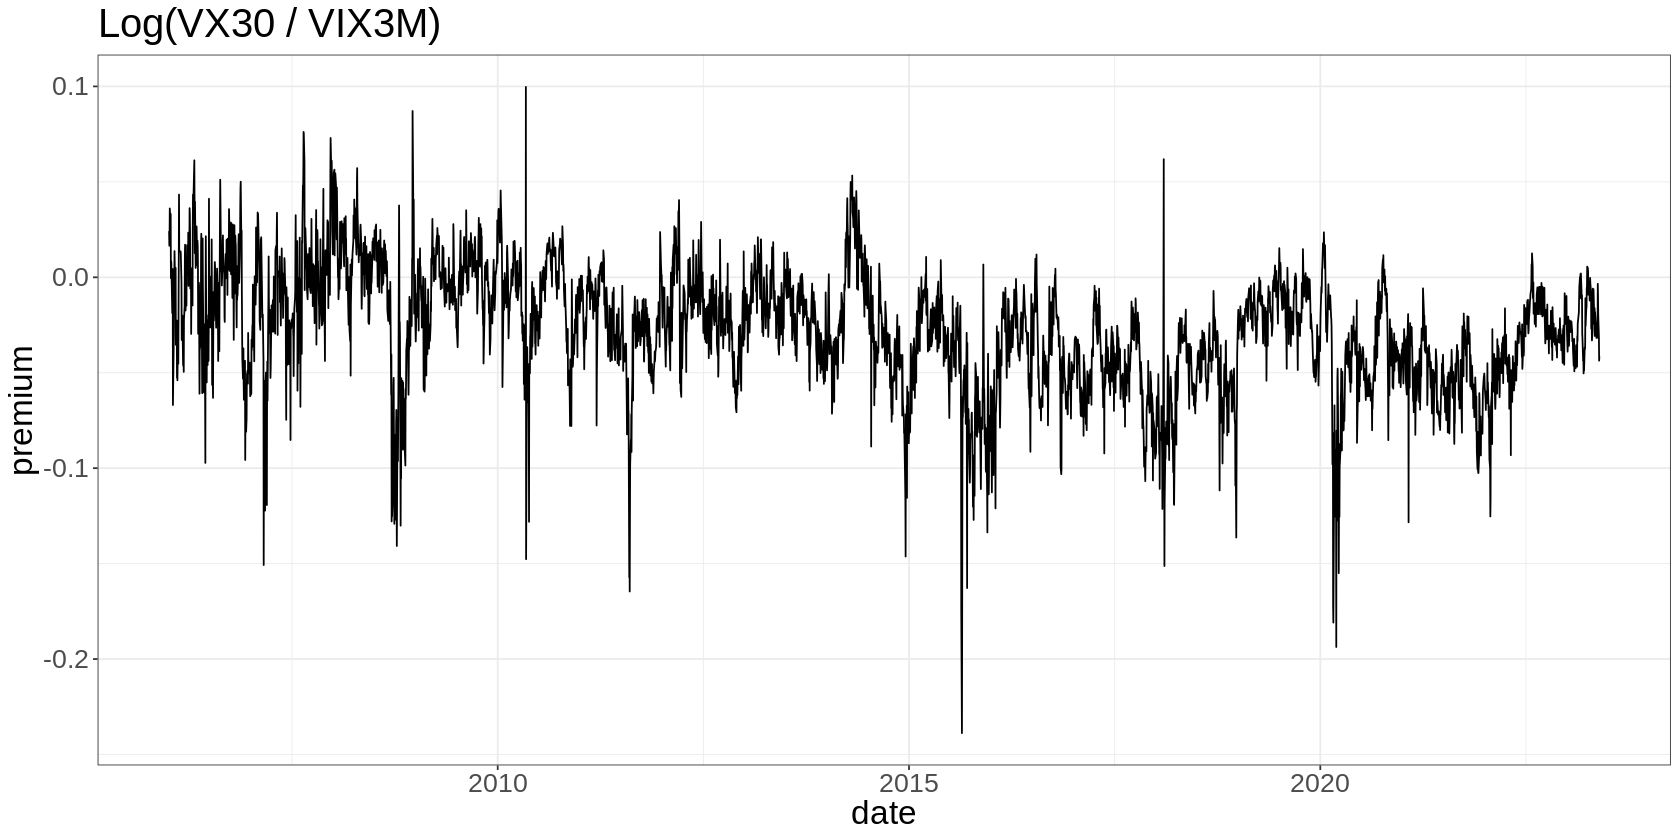

In [26]:
vix <- vx_summary %>% # 
  left_join(vix_indexes, by = 'date') %>%
  na.omit() %>%
  mutate(premium = log(vx30/VIX3M))

vix %>% head()

vix %>% 
  ggplot(aes(x=date, y=premium)) + geom_line() +
    ggtitle('Log(VX30 / VIX3M)')

Do a 252 day zscore on it

Warning message:
“Removed 251 rows containing missing values (`geom_line()`).”


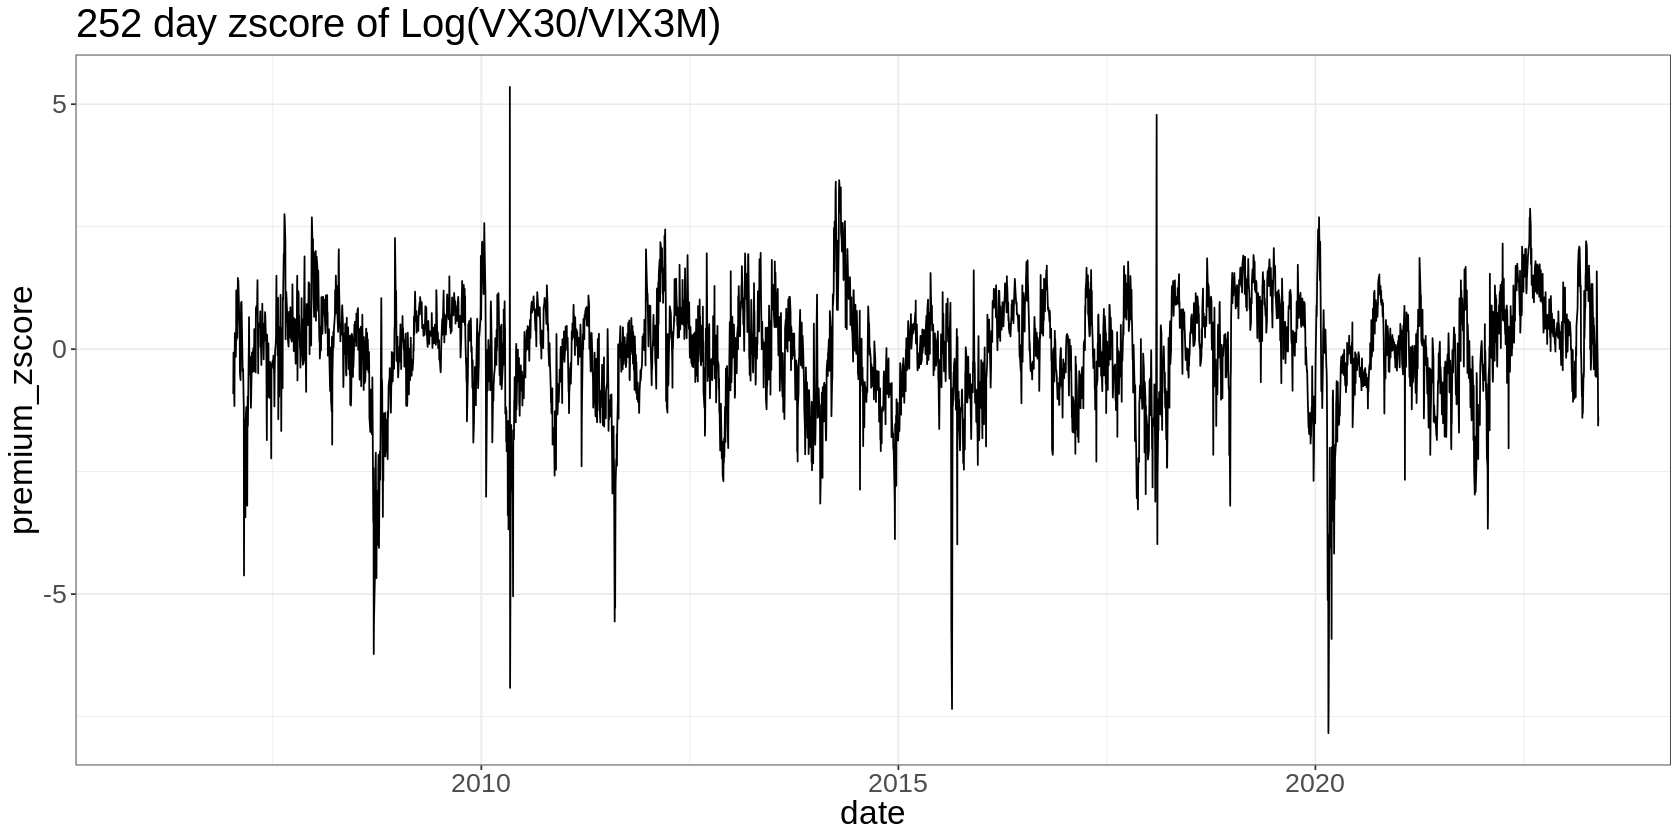

In [27]:
premium <- vix %>%
  ungroup() %>%
  mutate(
    premium_mean = roll::roll_mean(premium, 252),
    premium_sd = roll::roll_sd(premium, 252),
    premium_zscore = (premium - premium_mean)/premium_sd
  ) 
  
premium %>%
  ggplot(aes(x=date, y=premium_zscore)) + geom_line() +
    ggtitle('252 day zscore of Log(VX30/VIX3M)')

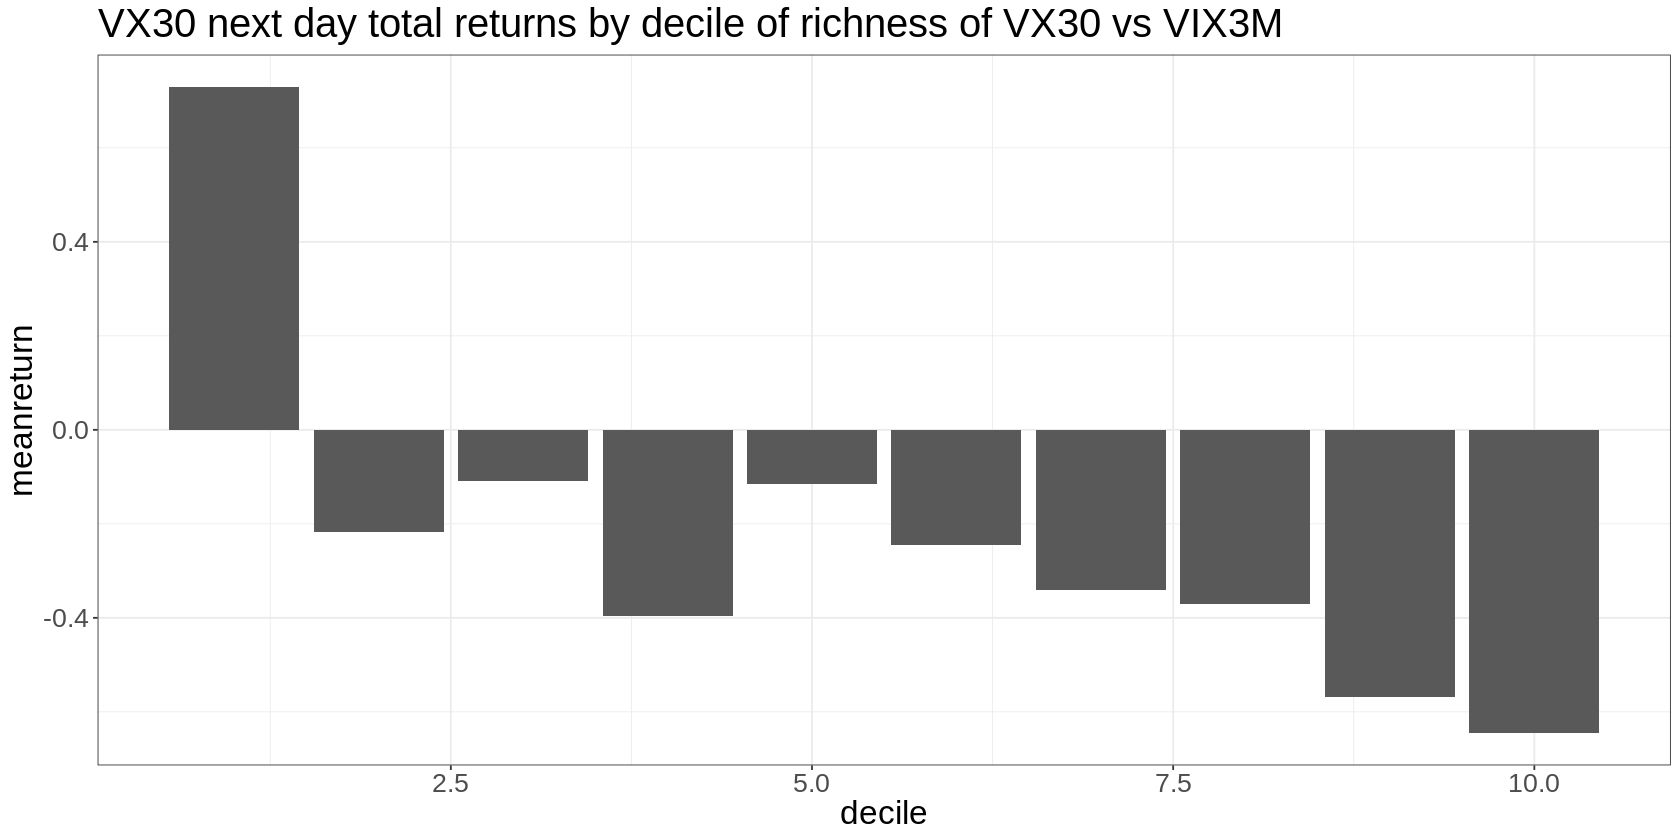

In [28]:
premium %>%
  mutate(
    lagpremium = lag(premium_zscore,1),
    decile = ntile(lagpremium, 10)
  ) %>%
  na.omit() %>%
  group_by(decile) %>%
  summarize(
    meanreturn = mean(vx30_tr) * 100,
    count = n(),
    minpremium = min(lagpremium),
    maxpremium = max(lagpremium)
  )  %>%
  ggplot(aes(x=decile, y = meanreturn)) + geom_bar(stat='identity') +
   ggtitle('VX30 next day total returns by decile of richness of VX30 vs VIX3M')

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 252 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 252 rows containing missing values (`geom_point()`).”


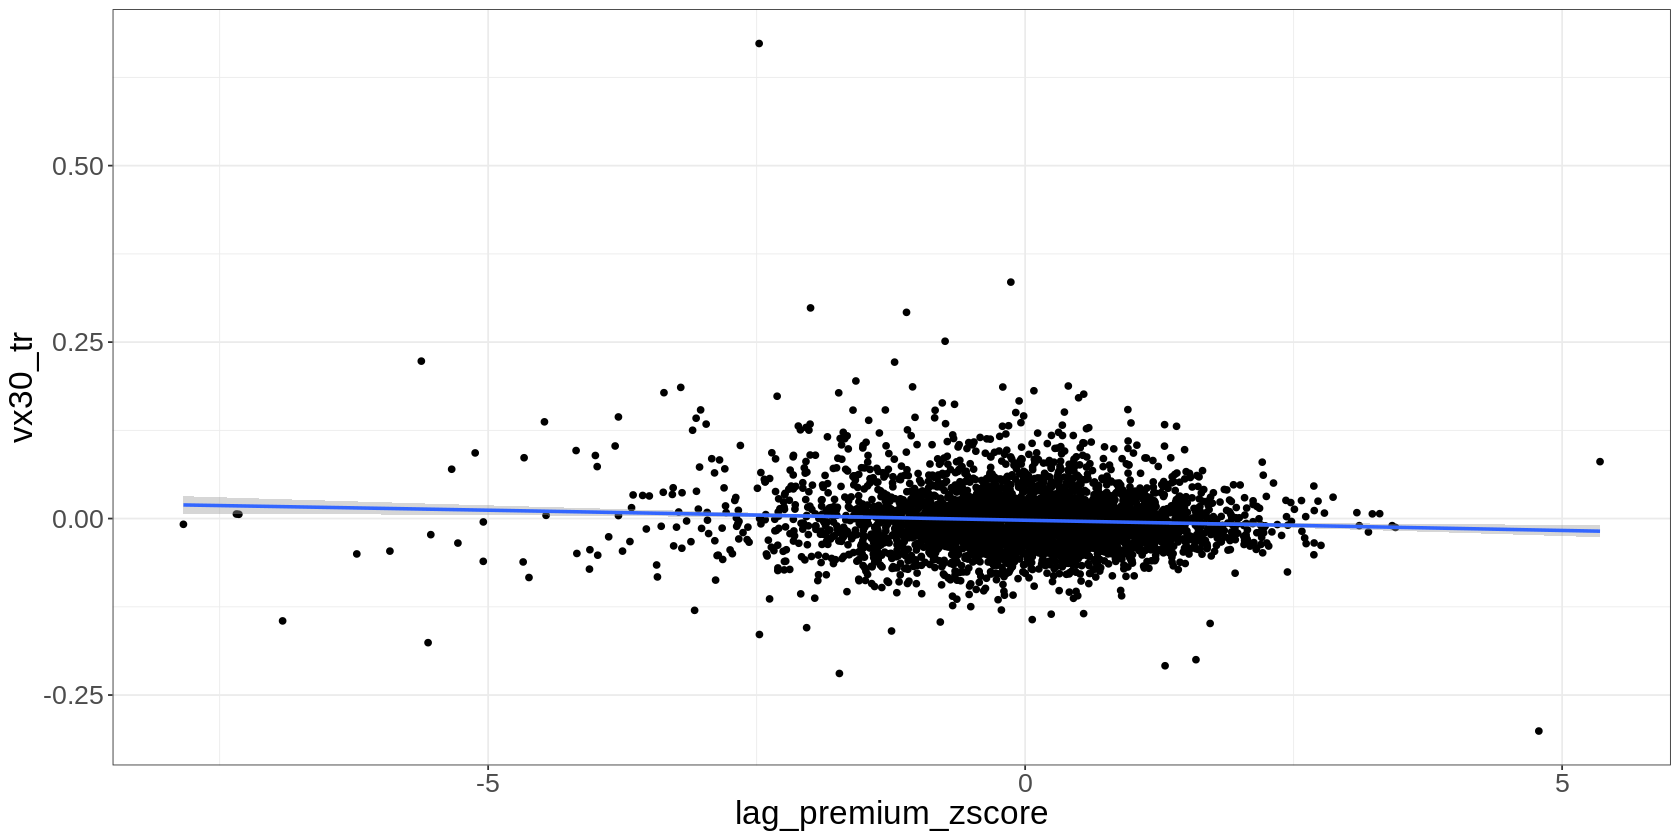

In [29]:
premium %>%
  mutate(lag_premium_zscore = lag(premium_zscore)) %>%
  ggplot(aes(x=lag_premium_zscore, y=vx30_tr)) + geom_point() + geom_smooth()

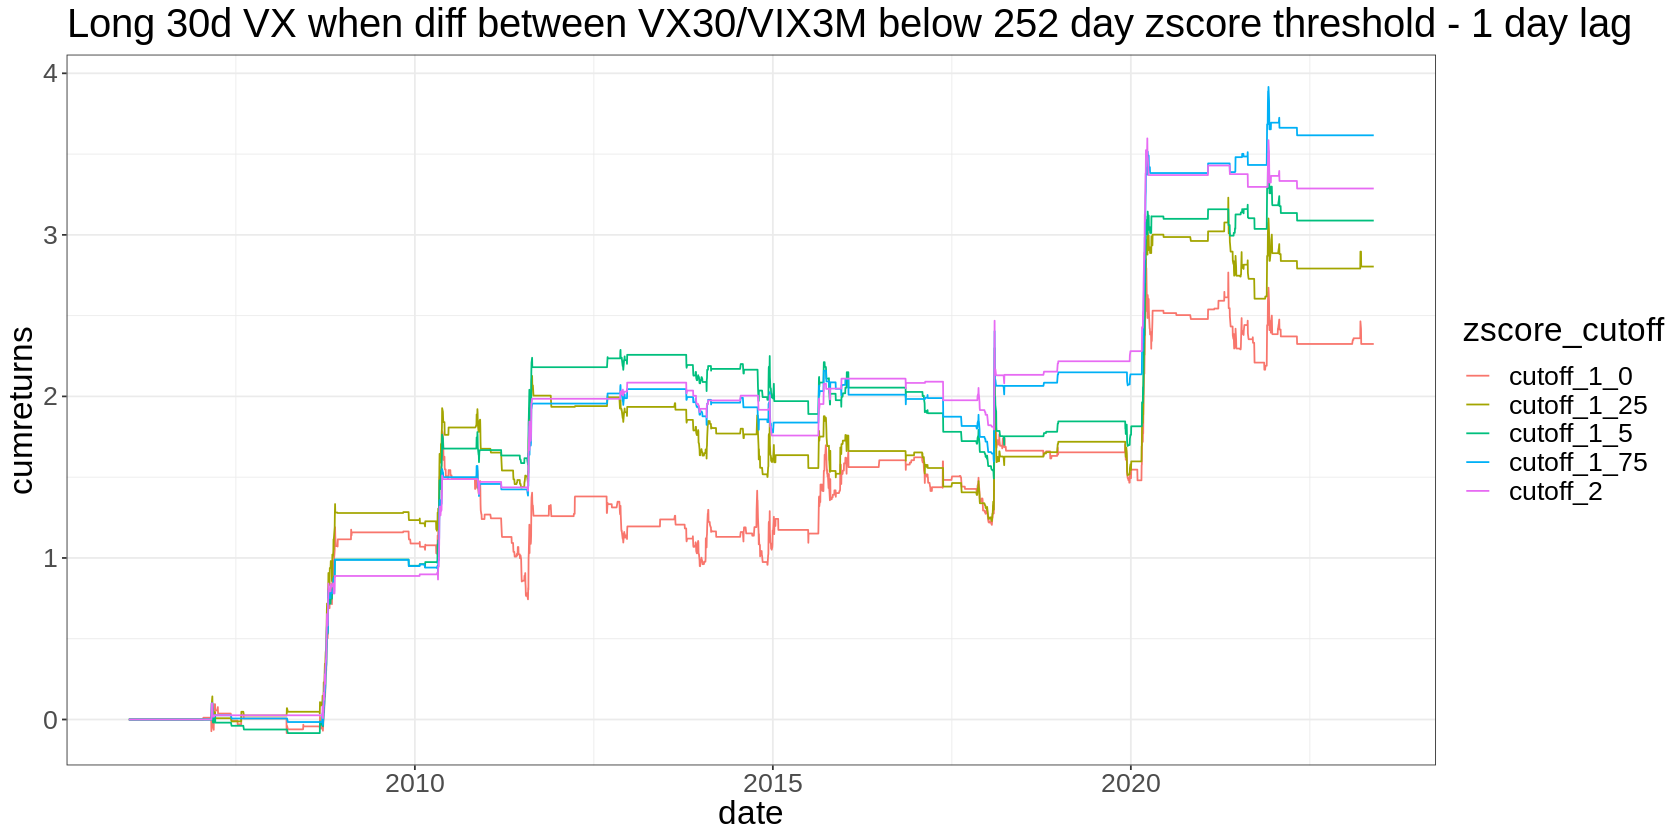

In [30]:
premium %>% 
   mutate(lag_premium_zscore = lag(premium_zscore,2)) %>%
   mutate(tr30 = vx30_tr) %>% # TODO: Remove
   arrange(date) %>%
   mutate(
    cutoff_1_0 = cumsum(case_when(lag_premium_zscore <= -1  ~ tr30 , lag_premium_zscore > -1 ~ -0, TRUE ~ 0)),
    cutoff_1_25 = cumsum(case_when(lag_premium_zscore <= -1.25  ~ tr30, lag_premium_zscore > -1.25 ~ 0, TRUE ~ 0)),
    cutoff_1_5 = cumsum(case_when(lag_premium_zscore <= -1.5  ~ tr30, lag_premium_zscore > -1.5 ~ 0, TRUE ~ 0)),
    cutoff_1_75 = cumsum(case_when(lag_premium_zscore <= -1.75  ~ tr30 , lag_premium_zscore > -1.75 ~ 0, TRUE ~ 0)),
    cutoff_2 = cumsum(case_when(lag_premium_zscore <= -2  ~ tr30 , lag_premium_zscore > -2 ~ 0, TRUE ~ 0))
   ) %>%
   select(c(date, starts_with('cutoff'))) %>%
   pivot_longer(-date, names_to = 'zscore_cutoff', values_to = 'cumreturns') %>% 
   ggplot(aes(x=date, y=cumreturns, color = zscore_cutoff)) + geom_line() + ggtitle('Long 30d VX when diff between VX30/VIX3M below 252 day zscore threshold - 1 day lag')


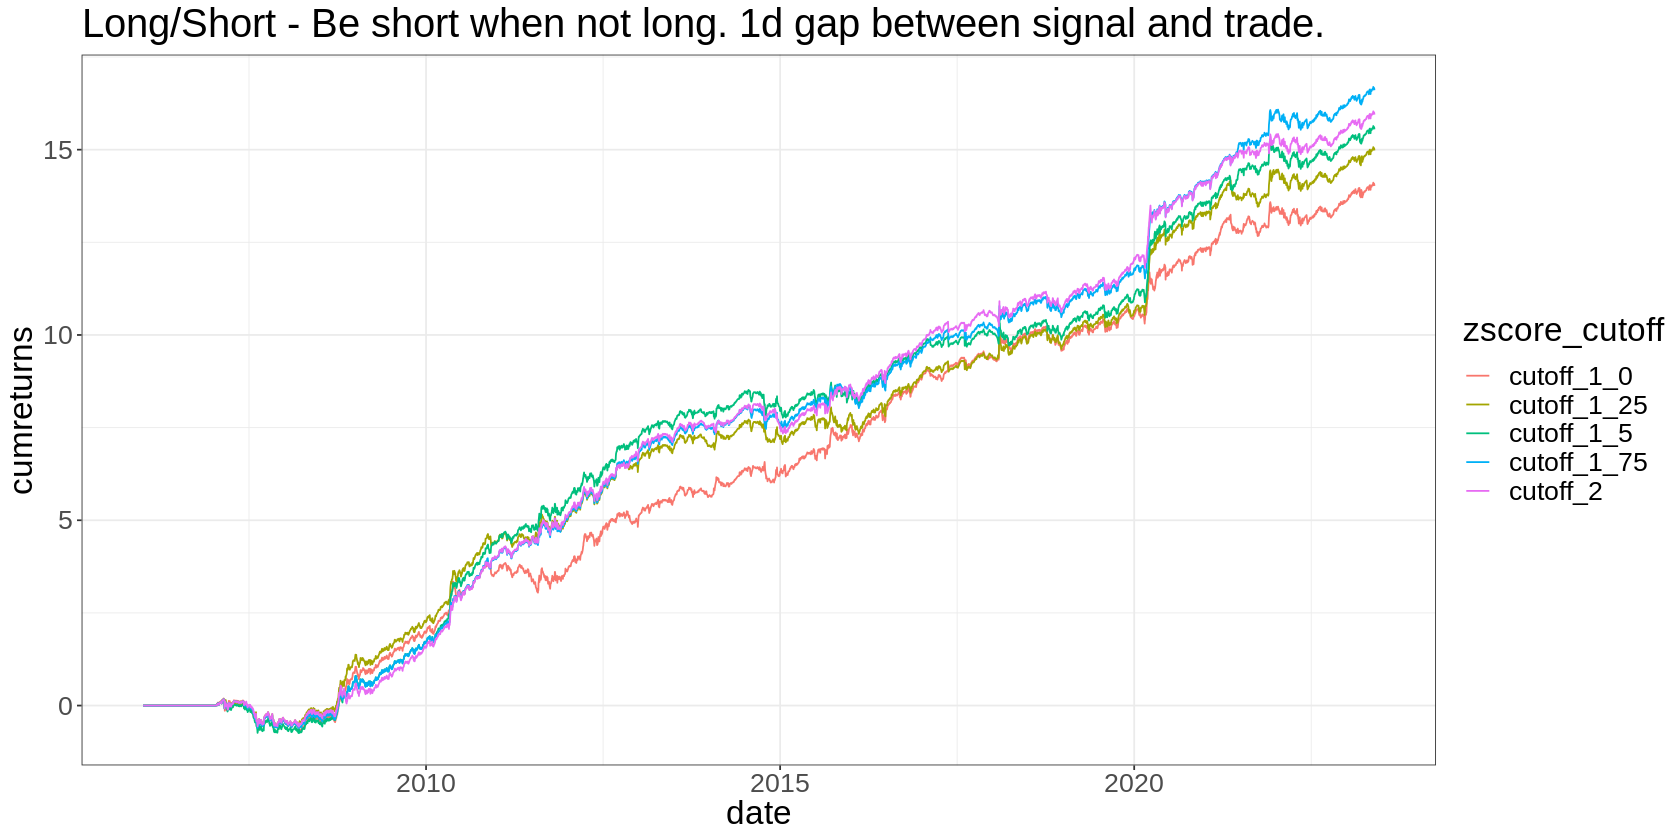

In [31]:
premium %>% 
   mutate(lag_premium_zscore = lag(premium_zscore,2)) %>%
   mutate(tr30 = vx30_tr) %>% 
   arrange(date) %>%
   mutate(
    cutoff_1_0 = cumsum(case_when(lag_premium_zscore <= -1  ~ tr30 , lag_premium_zscore > -1 ~ -tr30, TRUE ~ 0)),
    cutoff_1_25 = cumsum(case_when(lag_premium_zscore <= -1.25  ~ tr30, lag_premium_zscore > -1.25 ~ -tr30, TRUE ~ 0)),
    cutoff_1_5 = cumsum(case_when(lag_premium_zscore <= -1.5  ~ tr30, lag_premium_zscore > -1.5 ~ -tr30, TRUE ~ 0)),
    cutoff_1_75 = cumsum(case_when(lag_premium_zscore <= -1.75  ~ tr30 , lag_premium_zscore > -1.75 ~ -tr30, TRUE ~ 0)),
    cutoff_2 = cumsum(case_when(lag_premium_zscore <= -2  ~ tr30 , lag_premium_zscore > -2 ~ -tr30, TRUE ~ 0))
   ) %>%
   select(c(date, starts_with('cutoff'))) %>%
   pivot_longer(-date, names_to = 'zscore_cutoff', values_to = 'cumreturns') %>% 
   ggplot(aes(x=date, y=cumreturns, color = zscore_cutoff)) + geom_line() + ggtitle('Long/Short - Be short when not long. 1d gap between signal and trade.')